In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_bmimPF6_PR import configuration

In [2]:
m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False})

m1.fs.properties = GenericParameterBlock(default=configuration)

m1.fs.F101 = Flash(default={"property_package": m1.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m2 = ConcreteModel()

m2.fs = FlowsheetBlock(default={"dynamic": False})

m2.fs.properties = GenericParameterBlock(default=configuration)

m2.fs.F101 = Flash(default={"property_package": m2.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

2021-06-08 13:15:17 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-06-08 13:15:17 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [3]:
m1.fs.properties.PR_kappa['R32', 'R125'].fix(0.003831)
m1.fs.properties.PR_kappa['R125', 'R32'].fix(0.00271)

m1.fs.properties.PR_kappa['R32', 'R125'].fix(-0.002535)
m1.fs.properties.PR_kappa['R125', 'R32'].fix(-0.002535)
m1.fs.properties.PR_kappa['R32', 'bmimPF6'].fix(-0.01435)
m1.fs.properties.PR_kappa['bmimPF6', 'R32'].fix(0.9651)
m1.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(0.6312)
m1.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(0.0504)

m2.fs.properties.PR_kappa['R32', 'R125'].fix(0.003831)
m2.fs.properties.PR_kappa['R125', 'R32'].fix(0.00271)

m2.fs.properties.PR_kappa['R32', 'R125'].fix(-0.002535)
m2.fs.properties.PR_kappa['R125', 'R32'].fix(-0.002535)
m2.fs.properties.PR_kappa['R32', 'bmimPF6'].fix(-0.05059)
m2.fs.properties.PR_kappa['bmimPF6', 'R32'].fix(0.32934)
m2.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(1.5338)
m2.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(0.04538)


In [4]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [5]:
# Set pressures to loop over
T = [286,292,300,310,320,330,340,350,360,370,380,390,400]

# Set fraction of feed compositions of HFCs to loop over
P = [100000]

# Make outlet arrays
IL_x = np.zeros((len(T),len(P)))
IL_y = np.zeros((len(T),len(P)))
R32_x = np.zeros((len(T),len(P)))
R32_y = np.zeros((len(T),len(P)))
R125_x = np.zeros((len(T),len(P)))
R125_y = np.zeros((len(T),len(P))) 
L = np.zeros((len(T),len(P)))
V = np.zeros((len(T),len(P))) 

IL_x2 = np.zeros((len(T),len(P)))
IL_y2 = np.zeros((len(T),len(P)))
R32_x2 = np.zeros((len(T),len(P)))
R32_y2 = np.zeros((len(T),len(P)))
R125_x2 = np.zeros((len(T),len(P)))
R125_y2 = np.zeros((len(T),len(P))) 
L2 = np.zeros((len(T),len(P)))
V2 = np.zeros((len(T),len(P))) 

m1.fs.F101.inlet.flow_mol.fix(10)
m1.fs.F101.inlet.temperature.fix(371)
m1.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m1.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m1.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m1.fs.F101.inlet.pressure.fix(1000000)


m2.fs.F101.inlet.flow_mol.fix(10)
m2.fs.F101.inlet.temperature.fix(371)
m2.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m2.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m2.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m2.fs.F101.inlet.pressure.fix(1000000)

for i in range(len(T)):
    m1.fs.F101.vap_outlet.temperature.fix(T[i])

    m2.fs.F101.vap_outlet.temperature.fix(T[i])
        
    for j in range(len(P)):

        
        m2.fs.F101.inlet.pressure.fix(P[j])
        m2.fs.F101.vap_outlet.pressure.fix(P[j])

        m1.fs.F101.inlet.pressure.fix(P[j])
        m1.fs.F101.vap_outlet.pressure.fix(P[j])

        
        m1.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
        m2.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        # solve the model
        status = solver.solve(m1, tee = False)
        status = solver.solve(m2, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L[i,j] = value(m1.fs.F101.liq_outlet.flow_mol[0])
            V[i,j] = value(m1.fs.F101.vap_outlet.flow_mol[0])

            IL_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L2[i,j] = value(m2.fs.F101.liq_outlet.flow_mol[0])
            V2[i,j] = value(m2.fs.F101.vap_outlet.flow_mol[0])
            
            #Change this to feasible
            print("Running temperature:",T[i],"and HFC feed fraction",P[j])

        else:
            print('Infeasible.')

Running temperature: 286 and HFC feed fraction 100000
Running temperature: 292 and HFC feed fraction 100000
Running temperature: 300 and HFC feed fraction 100000
Running temperature: 310 and HFC feed fraction 100000
Running temperature: 320 and HFC feed fraction 100000
Running temperature: 330 and HFC feed fraction 100000
Running temperature: 340 and HFC feed fraction 100000
Running temperature: 350 and HFC feed fraction 100000
Running temperature: 360 and HFC feed fraction 100000
Running temperature: 370 and HFC feed fraction 100000
Running temperature: 380 and HFC feed fraction 100000
Running temperature: 390 and HFC feed fraction 100000
Running temperature: 400 and HFC feed fraction 100000


In [6]:
VR32_1 = np.zeros((len(T),len(P)))
VR125_1 = np.zeros((len(T),len(P)))
LR32_1 = np.zeros((len(T),len(P)))
LR125_1 = np.zeros((len(T),len(P)))

VR32_2 = np.zeros((len(T),len(P)))
VR125_2 = np.zeros((len(T),len(P)))
LR32_2 = np.zeros((len(T),len(P)))
LR125_2 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        VR32_1[i,j] = R32_y[i,j] * V[i,j]
        VR125_1[i,j] = R125_y[i,j] * V[i,j]
        LR32_1[i,j] = R32_x[i,j] * L[i,j]
        LR125_1[i,j] = R125_x[i,j] * L[i,j]

        VR32_2[i,j] = R32_y2[i,j] * V2[i,j]
        VR125_2[i,j] = R125_y2[i,j] * V2[i,j]
        LR32_2[i,j] = R32_x2[i,j] * L2[i,j]
        LR125_2[i,j] = R125_x2[i,j] * L2[i,j]

PVR32_1 = np.zeros((len(T),len(P)))
PVR125_1 = np.zeros((len(T),len(P)))
PLR32_1 = np.zeros((len(T),len(P)))
PLR125_1 = np.zeros((len(T),len(P)))

PVR32_2 = np.zeros((len(T),len(P)))
PVR125_2 = np.zeros((len(T),len(P)))
PLR32_2 = np.zeros((len(T),len(P)))
PLR125_2 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        PVR32_1[i,j] = VR32_1[i,j]/2.16
        PVR125_1[i,j] = VR125_1[i,j]/0.03
        PLR32_1[i,j] = LR32_1[i,j]/2.16
        PLR125_1[i,j] = LR125_1[i,j]/0.03

        PVR32_2[i,j] = VR32_2[i,j]/2.16
        PVR125_2[i,j] = VR125_2[i,j]/0.03
        PLR32_2[i,j] = LR32_2[i,j]/2.16
        PLR125_2[i,j] = LR125_2[i,j]/0.03
       


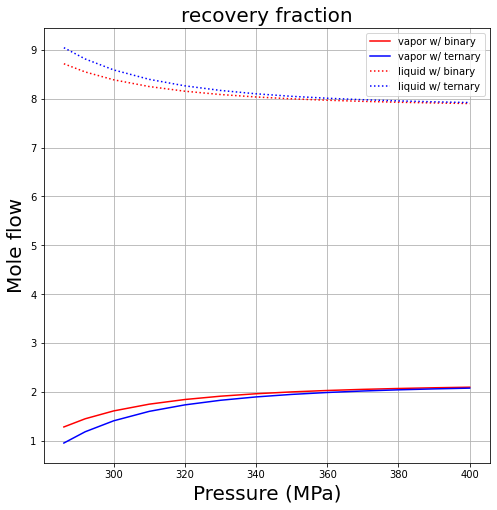

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

# plt.plot(P,R32_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc")  
# plt.plot(P,R125_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc") 


plt.plot(T,V[:,0],linestyle='-', color='red',label="vapor w/ binary")  
plt.plot(T,V2[:,0],linestyle='-', color='blue',label="vapor w/ ternary") 
plt.plot(T,L[:,0],linestyle='dotted', color='red',label="liquid w/ binary") 
plt.plot(T,L2[:,0],linestyle='dotted', color='blue',label="liquid w/ ternary") 

ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Mole flow',fontsize=20)
plt.grid(True)
plt.legend()
# ax.set_ylim([0.01, 0.25])
# ax.set_xlim([1e5, 2.5e5])
plt.show()

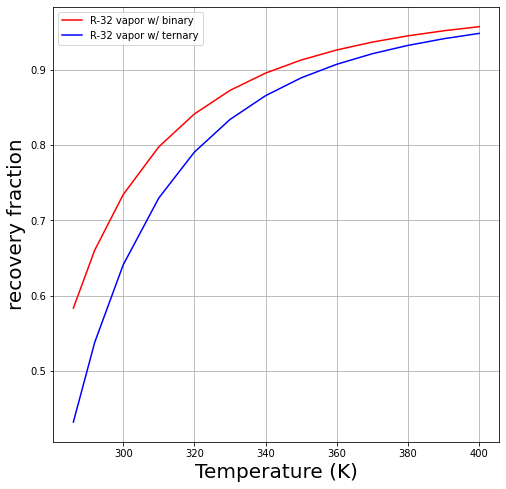

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

# plt.plot(P,R32_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc")  
# plt.plot(P,R125_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc") 


plt.plot(T,PVR32_1[:,0],linestyle='-', color='red',label="R-32 vapor w/ binary")  
plt.plot(T,PVR32_2[:,0],linestyle='-', color='blue',label="R-32 vapor w/ ternary") 
# plt.plot(T,L[:,0],linestyle='dotted', color='red',label="liquid w/ binary") 
# plt.plot(T,L2[:,0],linestyle='dotted', color='blue',label="liquid w/ ternary") 

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Temperature (K)',fontsize=20)
plt.ylabel('recovery fraction',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

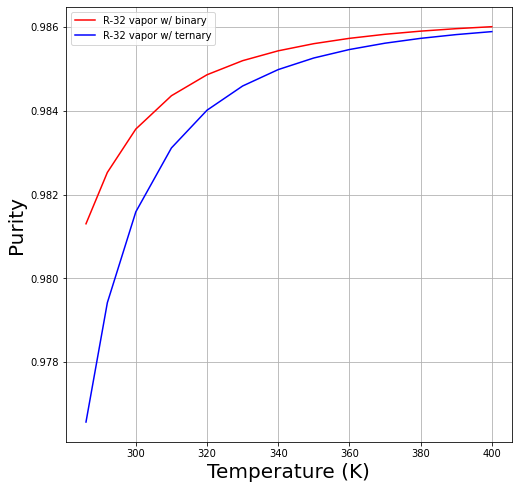

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

# plt.plot(P,R32_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc")  
# plt.plot(P,R125_y[0,:],linestyle='-', color='red',label="R-32 liquid bmimAc") 


# plt.plot(T,R32_y[:,0],linestyle='-', color='red',label="vapor w/ binary")  
# plt.plot(T,R32_y2[:,0],linestyle='-', color='blue',label="vapor w/ ternary") 
plt.plot(T,R32_y[:,0],linestyle='-', color='red',label="R-32 vapor w/ binary")  
plt.plot(T,R32_y2[:,0],linestyle='-', color='blue',label="R-32 vapor w/ ternary") 

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Temperature (K)',fontsize=20)
plt.ylabel('Purity',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()